In [1]:
# Date: Jan 12, 2022
# Author: Sashka Warner
# Desc: 
# -- Fetches historical air quality data from OpenWeather API,
# -- Fills gaps in air quality data based on averages for a given timestep, 
# -- Summarizes data by daily maximum values
# -- Creates and trains a Long Short-Term Memory (LSTM) model to predict future air quality
# -- Tunes model hyperparameters such as learning rate, number of epochs, and regularization through iterative experiments
# -- Saves trained model and scaler for use in Django application

In [2]:
# Imports
import os
import re
from dotenv import load_dotenv
from datetime import datetime, timedelta
import collections
import time
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

2023-01-13 02:21:30.181159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load credentials
load_dotenv()
WEATHER_API_KEY = os.getenv('WEATHER_API_KEY')

# Create basic URL for API call
WEATHER_API_URL = 'https://api.openweathermap.org/data/2.5/air_pollution/history'

In [4]:
def get_data(lat, long, date1, date2):
    '''
    Submits request to API for air quality data filtered based on provided lat, long, start date, and end date.
    Note: Can request max 1000 API calls / day without incurring overages.

    Parameters:
    ------------
    lat: Latitude (decimal degrees)
    long: Longitude (decimal degrees)
    date1: Start date (unix time, UTC time zone), e.g. start=1606488670
    date2: End date (unix time, UTC time zone), e.g. end=1606747870

    Returns:
    ------------
    1) json data from API on successful request, OR
    2) -1 if unsuccessful request

    '''
    # Create url from params
    params = {
        'lat': lat,
        'lon': long,
        'start': date1,
        'end': date2,
        'appid': WEATHER_API_KEY,
    }
    
    try:
        response = requests.get(url=WEATHER_API_URL, params=params)
        return response.json()['list']
    except:
        return -1

In [5]:
# Specify position
site_lat = 44.026280
site_long = -123.083715

# Specify time range for filtering
d1 = datetime(2017, 1, 1)
d2 = datetime(2022, 12, 31)
# Convert to unix time for api call
d1_unix = int(time.mktime(d1.timetuple()))
d2_unix = int(time.mktime(d2.timetuple()))

# Get air quality data formatted as json based on 
# query parameters
air_quality_json = get_data(
    lat=site_lat, 
    long=-site_long, 
    date1=d1_unix, 
    date2=d2_unix)

In [6]:
# Convert air quality data to DataFrame
air_quality = pd.json_normalize(air_quality_json)
# Format time stamps
air_quality['dt'] = pd.to_datetime(air_quality['dt'], unit='s')
air_quality.head()

,dt,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3
0,2020-11-25 01:00:00,1,236.99,0.60,3.56,66.52,1.97,7.08,8.78,17.73
1,2020-11-25 02:00:00,1,233.65,0.92,2.87,65.80,1.91,6.16,7.67,16.97
2,2020-11-25 03:00:00,1,223.64,0.91,2.16,63.66,1.62,4.53,5.74,13.81
3,2020-11-25 04:00:00,1,213.62,0.64,1.54,67.23,2.71,2.81,3.43,6.02
4,2020-11-25 05:00:00,1,210.29,0.60,1.56,69.38,3.58,2.30,2.70,3.33


In [7]:
# Remove dots from column names
air_quality.columns = air_quality.columns.map(lambda x: re.sub('\.', '_', x))
air_quality.reset_index(drop=True, inplace=True)
air_quality.head()

,dt,main_aqi,components_co,components_no,components_no2,components_o3,components_so2,components_pm2_5,components_pm10,components_nh3
0,2020-11-25 01:00:00,1,236.99,0.60,3.56,66.52,1.97,7.08,8.78,17.73
1,2020-11-25 02:00:00,1,233.65,0.92,2.87,65.80,1.91,6.16,7.67,16.97
2,2020-11-25 03:00:00,1,223.64,0.91,2.16,63.66,1.62,4.53,5.74,13.81
3,2020-11-25 04:00:00,1,213.62,0.64,1.54,67.23,2.71,2.81,3.43,6.02
4,2020-11-25 05:00:00,1,210.29,0.60,1.56,69.38,3.58,2.30,2.70,3.33


In [8]:
# Check types and NAs
for i in air_quality.columns:
    print(i, 'type:', air_quality[i].map(lambda x: type(x)).unique(), 'Has NAs:', any(air_quality[i].isna()))

dt type: [<class 'pandas._libs.tslibs.timestamps.Timestamp'>] Has NAs: False
main_aqi type: [<class 'int'>] Has NAs: False
components_co type: [<class 'float'>] Has NAs: False
components_no type: [<class 'float'>] Has NAs: False
components_no2 type: [<class 'float'>] Has NAs: False
components_o3 type: [<class 'float'>] Has NAs: False
components_so2 type: [<class 'float'>] Has NAs: False
components_pm2_5 type: [<class 'float'>] Has NAs: False
components_pm10 type: [<class 'float'>] Has NAs: False
components_nh3 type: [<class 'float'>] Has NAs: False


In [9]:
# Examine gaps in time series
air_quality.at[1,'dt'] - air_quality.at[0, 'dt']

# Extract date time column
aq_dates = air_quality['dt']

# Create dict to store unique time deltas
unique_deltas = collections.defaultdict(int)

# Count instances of unique time deltas
for i, val in enumerate(aq_dates):
    if(i > 0):
        t_delta = aq_dates[i] - aq_dates[i-1]
        unique_deltas[t_delta] += 1
        #Examine outliers and their PM2.5 values
        if(t_delta != timedelta(hours=1)):
            print(
                't-1:', aq_dates[i-1], 'PM2.5:', air_quality.at[i-1, 'components_pm2_5'], 
                't:', aq_dates[i], 'PM2.5:', air_quality.at[i, 'components_pm2_5'])
    
unique_deltas

t-1: 2021-01-27 00:00:00 PM2.5: 3.64 t: 2021-01-28 01:00:00 PM2.5: 2.13
t-1: 2022-01-23 00:00:00 PM2.5: 51.82 t: 2022-01-24 01:00:00 PM2.5: 32.85
t-1: 2022-02-20 00:00:00 PM2.5: 1.46 t: 2022-02-21 01:00:00 PM2.5: 1.87
t-1: 2022-07-20 00:00:00 PM2.5: 9.06 t: 2022-07-22 01:00:00 PM2.5: 35.14
t-1: 2022-12-09 00:00:00 PM2.5: 6.05 t: 2022-12-11 01:00:00 PM2.5: 4.42
t-1: 2022-12-25 00:00:00 PM2.5: 3.42 t: 2022-12-26 01:00:00 PM2.5: 18.55


defaultdict(int,
            {Timedelta('0 days 01:00:00'): 18193,
             Timedelta('1 days 01:00:00'): 4,
             Timedelta('2 days 01:00:00'): 2})

In [10]:
# Create list for filled time steps
fill_steps = []

# Define variable for 1 hr difference
one_hr = timedelta(hours=1)

# Add time steps for gaps in time series
for i, val in enumerate(aq_dates):
    if(i > 0):
        # Create counter for while loop
        # if we need to gap fill the timeseries
        loop_counter = i - 1
        # Get [i-1] timestep
        last_timestep = aq_dates[i-1]
        # Get [i] timestep
        current_timestep = aq_dates[i]
        # Calculate time delta
        t_delta = current_timestep - last_timestep
        
        while(t_delta > one_hr):
            # Add one hour to the [i-1] timestep
            new_timestep = last_timestep + one_hr
            #print(f'Current timestep: {last_timestep}, Adding timestep: {new_timestep}')
            # Add the new timestep to the list
            fill_steps.append(new_timestep)
            # Calculate time delta from [i] timestep
            t_delta = aq_dates[i] - new_timestep
            #print(f't_delta: {t_delta > one_hr}')
            # Increment the counter
            loop_counter += 1
            # Store the current timestep so we can add one hour to 
            # this value if needed
            last_timestep = new_timestep

len(fill_steps)

# Check that no duplicates in time steps
#duplicates = False
#for i in collections.Counter(fill_steps):
#    if(collections.Counter(fill_steps)[i] > 1):
#        duplicates = True

#print(duplicates)
#list(map(lambda x: x if x[0] else '', collections.Counter(fill_steps)))

192

In [11]:
# Check that no duplicates in source data
#dup = False
#count_dt = collections.Counter(air_quality['dt'])
#for i in count_dt:
#    if(count_dt[i] > 1):
#        dup = True

#print(dup)

In [12]:
# Create dataframe from filled timesteps
fill_df = pd.DataFrame(data=fill_steps, columns=['dt'])

# Join new timestamps to dataframe
aq_join_fill = air_quality.merge(right=fill_df, on='dt', how='outer', suffixes=['', '_join'])

# Examine missing data after join
aq_join_fill[aq_join_fill['components_pm2_5'].isna()].head()

,dt,main_aqi,components_co,components_no,components_no2,components_o3,components_so2,components_pm2_5,components_pm10,components_nh3
18200,2021-01-27 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18201,2021-01-27 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18202,2021-01-27 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18203,2021-01-27 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18204,2021-01-27 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Check that no duplicates in first join
#dup = False
#count_dt = collections.Counter(aq_join_fill['dt'])
#for i in count_dt:
#    if(count_dt[i] > 1):
#        dup = True

#print(dup)

In [14]:
# Create copy of dt col before setting dt index so we don't lose time data
# Create DateTime index
aq_join_fill['DateTime'] = aq_join_fill['dt']
aq_join_fill_dt = aq_join_fill.set_index('dt')
#print(aq_join_fill.head())

# Average values for each day & hour to fill in missing values in the time series
averages = aq_join_fill_dt.groupby(
    [
        aq_join_fill_dt.index.strftime('%m'), # Pad dates to avoid duplicates
        aq_join_fill_dt.index.strftime('%d'), 
        aq_join_fill_dt.index.strftime('%H')]).mean()
        
#averages.shape
#print(averages.head())
#Check if PM2.5 data has nulls after averaging
print('NAs in PM2.5 data after averaging over time: ', averages['components_pm2_5'].isna().sum())

NAs in PM2.5 data after averaging over time:  0


/var/folders/bx/8_p36bpd14nckr66rq2kk6kc0000gn/T/ipykernel_19906/1078082750.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aq_join_fill_dt.index.strftime('%H')]).mean()


In [15]:
# Prep tables for join
averages['m_d_h'] = averages.index.map(lambda x: str(x[0]) + str(x[1]) + str(x[2]))
#any(averages.duplicated(subset=['m_d_h']))
aq_join_fill_dt['m_d_h'] = aq_join_fill_dt.index.map(lambda x: x.strftime('%m') + x.strftime('%d') + x.strftime('%H'))
averages.head()
#aq_join_fill_dt.head()

main_aqi  components_co  components_no  components_no2  \
dt dt dt                                                           
01 01 00       1.5        363.825          0.010          12.040   
      01       1.5        367.165          0.485          11.225   
      02       2.0        365.495          1.380          10.455   
      03       2.0        378.850          2.245          12.210   
      04       2.0        437.260          5.655          15.060   

          components_o3  components_so2  components_pm2_5  components_pm10  \
dt dt dt                                                                     
01 01 00         52.570           6.695            11.065           14.460   
      01         53.640           6.500            11.760           15.430   
      02         55.075           7.315            11.615           15.565   
      03         54.005          11.965            12.535           17.165   
      04         61.870          28.610            13.110           18.350   

          components_nh3   m_d_h  
dt dt dt                          
01 01 00          16.020  010100  
      01          16.025  010101  
      02          15.960  010102  
      03          15.830  010103  
      04          10.260  010104

In [16]:
# Join averages to time series
#print(aq_join_fill_dt.shape)
aq_averaged = aq_join_fill_dt.merge(right=averages, how='left', on = 'm_d_h', suffixes= ('', '_avg'))
#aq_averaged.reset_index(drop=True, inplace=True)
# Check duplicates
print(f'Has duplicate dates? {any(aq_averaged["DateTime"].duplicated())}')

# Check which dates have missing data
missing_data = aq_averaged[aq_averaged['components_co'].isna()]['DateTime'].to_list() 
print(f'Null dates match initial gap filling? {missing_data == fill_steps}\n# Missing records: {len(missing_data)}')

Has duplicate dates? False
Null dates match initial gap filling? True
# Missing records: 192


In [17]:
# Compile original data column names
data_cols = [
    'main_aqi',
    'components_co', 
    'components_no', 
    'components_no2',
    'components_o3',
    'components_so2',
    'components_pm2_5',
    'components_pm10',
    'components_nh3']

# Update missing values with joined data
for col_name in data_cols:
    aq_averaged[col_name] = aq_averaged[col_name].where(aq_averaged[col_name].notnull(), aq_averaged[col_name + '_avg'])


# Check that all NAs have been removed from PM2pt5 data
print(f'Number of missing records: {aq_averaged["components_pm2_5"].isna().sum()}')

Number of missing records: 0


In [18]:
# Extract only columns of interest
data_cols.insert(0, 'DateTime')
aq_averaged = aq_averaged[data_cols]
aq_averaged.head()

,DateTime,main_aqi,components_co,components_no,components_no2,components_o3,components_so2,components_pm2_5,components_pm10,components_nh3
0,2020-11-25 01:00:00,1.0,236.99,0.60,3.56,66.52,1.97,7.08,8.78,17.73
1,2020-11-25 02:00:00,1.0,233.65,0.92,2.87,65.80,1.91,6.16,7.67,16.97
2,2020-11-25 03:00:00,1.0,223.64,0.91,2.16,63.66,1.62,4.53,5.74,13.81
3,2020-11-25 04:00:00,1.0,213.62,0.64,1.54,67.23,2.71,2.81,3.43,6.02
4,2020-11-25 05:00:00,1.0,210.29,0.60,1.56,69.38,3.58,2.30,2.70,3.33


<AxesSubplot: xlabel='year_month', ylabel='components_pm2_5'>

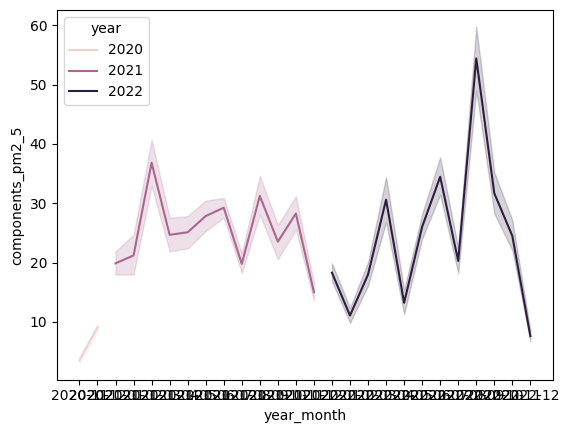

In [19]:
# Plot data over time
aq_by_month = aq_averaged.copy()
aq_by_month['year'] = aq_by_month['DateTime'].map(lambda x: x.year)
aq_by_month['month'] = aq_by_month['DateTime'].map(lambda x: x.month)
aq_by_month['year_month'] = aq_by_month['DateTime'].map(lambda x: x.strftime('%Y-%m'))
aq_by_month.head()
sns.lineplot(x='year_month', y='components_pm2_5', hue='year', data=aq_by_month)

<AxesSubplot: xlabel='month', ylabel='components_pm2_5'>

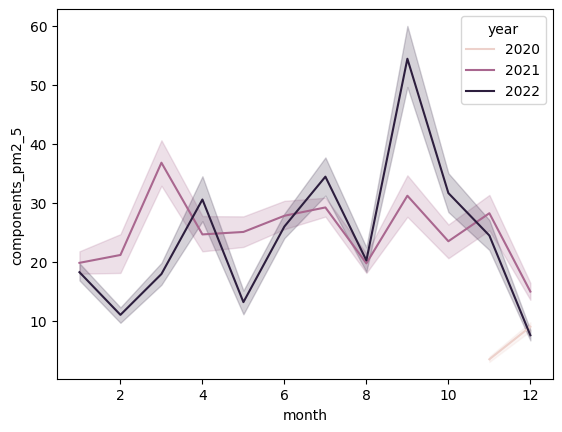

In [20]:
# Plot by month:
# Note that: for the two years of data, fire season seems to have had worst monthly air quality for the second year
# Potential increasing trend as well as seasonabl trend
sns.lineplot(x='month', y='components_pm2_5', hue='year', data=aq_by_month)

<AxesSubplot: xlabel='year_month', ylabel='pm2_5_lag1'>

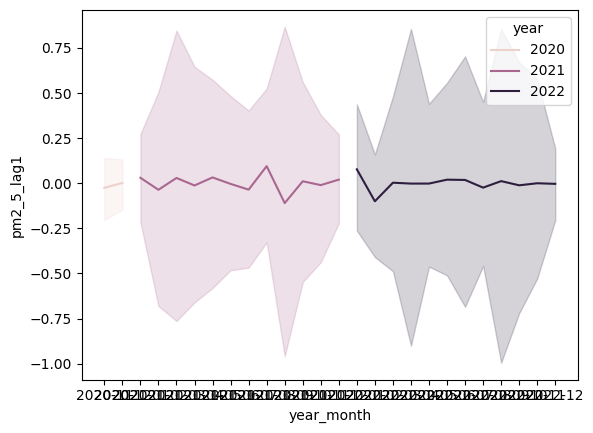

In [21]:
# Transform time series to stationary:
# Create a differenced series to remove any increasing trend
def difference(dataset, interval=1):
    diff = [None] * interval # Start with null value(s) so length matches the other data frames
    # Iterate through 1 - n records
    for i in range(interval, len(dataset)):
        # Calculate difference between current and timestep and past timestep
        value = dataset[i] - dataset[i - interval]
        diff.append(value)

    return pd.Series(diff)

aq_differenced = difference(dataset=aq_by_month['components_pm2_5'])

# Add the differenced data back to the original data frame
aq_by_month['pm2_5_lag1'] = aq_differenced

# Plot the differenced data over time
sns.lineplot(x=aq_by_month['year_month'], y=aq_by_month['pm2_5_lag1'], hue=aq_by_month['year'])

<AxesSubplot: xlabel='month', ylabel='pm2_5_lag1'>

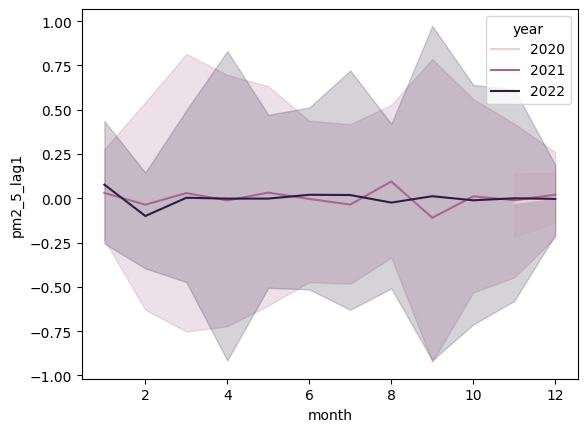

In [22]:
#Plot the differenced data by month
# There are still some seasonal variations, but there isn't enough data 
# to seasonally differenc the whole
sns.lineplot(x=aq_by_month['month'], y=aq_by_month['pm2_5_lag1'], hue=aq_by_month['year'])

<AxesSubplot: xlabel='year_month', ylabel='pm2_5_lag1_lagYr'>

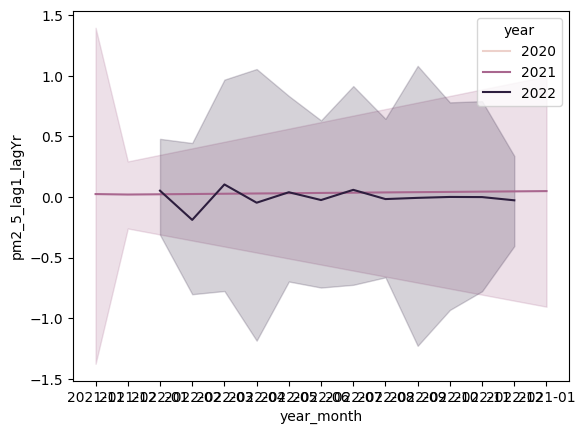

In [23]:
# (Transforming data to stationary cont'd)
# 2. Apply seasonal lag to remove variations due to winter and summer (eg fire season)
aq_differenced_1year = difference(dataset=aq_by_month['pm2_5_lag1'], interval = 365*24)

# Add the differenced data back to the original data frame
aq_by_month['pm2_5_lag1_lagYr'] = aq_differenced_1year

# Plot the differenced data over time
# Removes some of the variation but does not appear to make a substantial difference
# For now, we will proceed with the first differenced data of lag=1
sns.lineplot(x=aq_by_month['year_month'].iloc[365*24:], y=aq_by_month['pm2_5_lag1_lagYr'].iloc[365*24:], hue=aq_by_month['year'])

In [24]:
# Need to calculate 12 hr weighted averages for EPA NowCast methodology
# See: https://usepa.servicenowservices.com/airnow?id=kb_article_view&sys_id=bb8b65ef1b06bc10028420eae54bcb98&spa=1
# Use rolling `apply` for every 12 hrs
# This will generate a new col of NowCast values that takes into context the previous 12 hrs
# Then for the forecast we could train the model to forecast the next 24 - 48 hrs

NOWCAST_WINDOW = 12

def now_cast_pm(input_arr):
    '''
    Apply EPA NowCast algorithm on sequence of timeseries (excluding final stage of converting to AQI).

    Parameters:
    input_arr --- nd array or list containing air quality particulate matter time series

    Returns:
    now_cast -- numeric weighted average of timeseries values in same units as original time series data
    '''
    # Select the minimum and maximum PM measurements.
    min_val, max_val = min(input_arr), max(input_arr)
    # Subtract the minimum measurement from the maximum measurement to get the range.
    arr_range = max_val - min_val
    # Divide the range by the maximum measurement in the 12 hour period to get the scaled rate of change.
    rate_of_change = arr_range / max_val
    # Subtract the scaled rate of change from 1 to get the weight factor. 
    # The weight factor must be between .5 and 1. The minimum limit approximates a 3-hour average.
    weight_factor = 1 - rate_of_change
    #If the weight factor is less than 0.5, then set it equal to 0.5.
    if(weight_factor < 0.5):
        weight_factor = 0.5

    # Multiply each hourly measurement by the weight factor raised to the 
    # power of the number of hours ago the value was measured 
    # (for the current hour, the factor is raised to the zero power).
    weight_factor_pow = list()
    products = list()
    for i, val in enumerate(list(reversed(input_arr))):
        wf_pow = pow(weight_factor, i)
        weight_factor_pow.append(wf_pow)
        products.append(val * wf_pow)
        
    # Compute the NowCast by summing the products from Step 6 and 
    # dividing by the sum of the weight factor raised to the power
    # of the number of hours ago each value was measured.
    now_cast = (sum(products)) / (sum(weight_factor_pow))
    return now_cast

    #Convert this value to an AQI. A concentration to AQI converter is available at https://airnow.gov/aqi/aqi-calculator-concentration
    # Note -> saving AQI conversions until the Django application to reduce transform operations at this stage

# Apply NowCast function to pm2.5 data
aq_by_month['pm2_5_nowcast'] = aq_by_month['components_pm2_5'].rolling(window=NOWCAST_WINDOW).apply(now_cast_pm, raw=True) # Need raw=True to pass input as ndarray

In [25]:
# Check NAs
aq_by_month['pm2_5_nowcast'].isna().sum() # Should only return the first values that were used for rolling avg

11

<AxesSubplot: xlabel='year_month', ylabel='pm2_5_nowcast'>

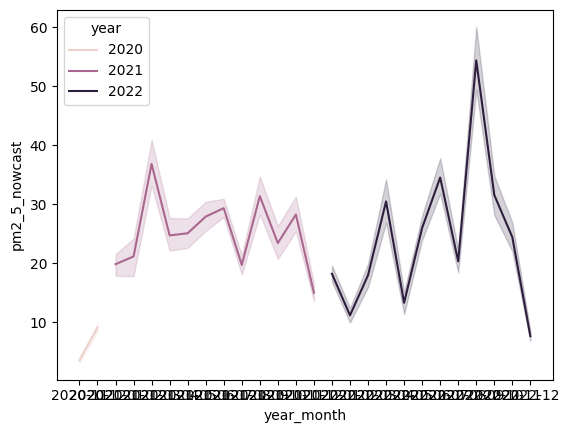

In [26]:
# Plot the nowcast pm2.5 data over time
sns.lineplot(x=aq_by_month['year_month'], y=aq_by_month['pm2_5_nowcast'], hue=aq_by_month['year'])

<AxesSubplot: xlabel='year_month', ylabel='pm2_5_nowcast_lag1'>

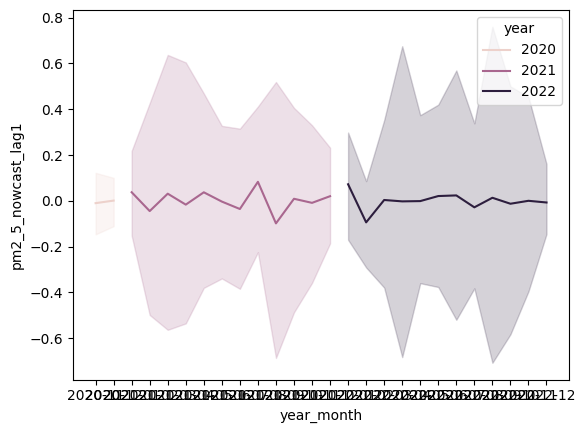

In [27]:
# Difference the NowCast series
aq_nowcast_diff = difference(dataset=aq_by_month['pm2_5_nowcast'])

# Add the differenced data back to the original data frame
aq_by_month['pm2_5_nowcast_lag1'] = aq_nowcast_diff

# Plot the differenced data over time
sns.lineplot(x=aq_by_month['year_month'], y=aq_by_month['pm2_5_nowcast_lag1'], hue=aq_by_month['year'])

In [28]:
# Difference and scale data to [-1, 1]
def diff_scale(data, interval=1, return_arr=False):
    # Difference the data to remove any long term trend
    data_diff = difference(data, interval=interval)
    # Slice array to ignore first 'interval' # of elements (null) and convert to 2-D numpy array for scaler
    data_diff = np.array(data_diff[interval:])
    # Reshape into array for scaler (observations, features)
    data_diff = data_diff.reshape(len(data_diff), 1)
    # Fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(data_diff)
    # Scale the data
    diff_scaled = scaler.transform(data_diff)

    # If return_arr flag is True, convert back to 1-D numpy array
    if(return_arr):
        diff_scaled = diff_scaled[:, 0]

    # Otherwise return 2-D numpy array
    return diff_scaled, scaler
 
def invert_scale_diff(yhat, prev, scaler, steps_in, steps_out):
    '''
    Invert scaling and remove differencing for forecasted values
    
    Parameters:
    yhat --- scaled and differenced forecast data as 2-D ndarray of shape [samples, timesteps]
    prev --- raw data as 3-D ndarray of shape [samples, timesteps, features]
    scaler --- trained sklearn scaler object
    steps_in --- number of input steps (Note: currently, # steps_in must be >= # steps_out)
    steps_out -- number of output steps

    Returns:
    1) inverted_rm_diff --- forecast data with no scaling/differencing as 2-D ndarray of shape [samples, timesteps], OR
    2) -1 for invalid parameters
    '''
    if(steps_in < steps_out):
        return -1

    # Wrap forecasted values in numpy array and reshape for scaler
    #array = np.array(yhat)
    #array = array.reshape(len(array))
    # Invert scaling 
    inverted = scaler.inverse_transform(yhat)
    #print("inverted:",inverted)
    #print("prev:", prev[:,(steps_in - steps_out):,0])
    #inverted_val = inverted[0, 0]
    # Add the previous values to the forecasted values to remove differencing

    # Take difference of steps_in and steps_out so that if we can add the two datasets without changing shape
    inverted_rm_diff = inverted + prev[:,(steps_in - steps_out):,0] # 0 is because only one feature currently

    return inverted_rm_diff

In [29]:
# Remove nulls from first window of NowCast data
nowcast_clean = aq_by_month['pm2_5_nowcast'].iloc[NOWCAST_WINDOW-1:]
nowcast_clean.reset_index(drop=True, inplace=True)

# Difference and scale the data
DIFFERENCE_INTERVAL = 1
nowcast_diff, scaler = diff_scale(nowcast_clean, interval=DIFFERENCE_INTERVAL, return_arr=True)
nowcast_diff.shape

(18380,)

In [30]:
# Transform NowCast data to supervised learning problem
# Split a univariate sequence into samples
def timeseries_to_supervised(sequence, n_steps_in, n_steps_out):
	'''
	Convert time series data to supervised learning problem.
	
	Parameters:
	sequence --- list or ndarray of timeseries data
	n_steps_in --- number of steps for X
	n_steps_out --- number of steps for y

	Returns:
	np.array(X), np.array(y)
	'''
	X, y = list(), list()
	for i in range(len(sequence)):
		# Find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# Check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# Gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# Define input sequence
#raw_values = nowcast_clean

# Choose a number of time steps
#n_steps_in, n_steps_out = 48, 48 # Two days of NowCast data to forecast two days of NowCast data
n_steps_in, n_steps_out = 24, 12 # Steps in = one day, steps out = 1/2 day
# Split original data into X and y
# Make sure to remove the first `DIFFERENCE_INTERVAL` # of rows because 
# we want to eventually add it to the differenced forecast
# such that the forecast for X_diff[t] (yhat_diff[t] which is differenced by `DIFFERENCE_INTERVAL` steps)
# plus the raw value for X[t] is equal to yhat[t] in same units as original data
# There is no forecast for the first `DIFFERENCE_INTERVAL` # of steps so we don't care about those samples
X_raw, y_raw = timeseries_to_supervised(nowcast_clean.iloc[DIFFERENCE_INTERVAL:], n_steps_in, n_steps_out)
print(X_raw.shape, y_raw.shape)
# Split differenced data into X and y
X, y = timeseries_to_supervised(nowcast_diff, n_steps_in, n_steps_out)
print(X.shape, y.shape) #X.shape[0] will be (n observations - steps_in - steps_out + 1)
# The + 1 is because when you get to the distance (steps_in + steps_out) from the end of the data, you include that pair and no more

# Split the X and y data into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Split raw values into X, y test, train so that we can evaluate error later on
# Make sure to set shuffle=False for timeseries
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, shuffle=False)
#print(X_train_raw.shape, X_test_raw.shape)


# Reshape from [samples, timesteps] into [samples, timesteps, features] for model fit
# and for ease of removing differencing later on
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_train_raw = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1], n_features))
X_test_raw = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1], n_features))
print(X_train.shape, X_test.shape)
print(X_train_raw.shape, X_test_raw.shape)
print(y_train.shape)

/var/folders/bx/8_p36bpd14nckr66rq2kk6kc0000gn/T/ipykernel_19906/1455506212.py:24: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]


(18345, 24) (18345, 12)
(18345, 24) (18345, 12)
(14676, 24) (3669, 24) (14676, 12) (3669, 12)
(14676, 24, 1) (3669, 24, 1)
(14676, 24, 1) (3669, 24, 1)
(14676, 12)


In [31]:
# Evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, X_scaled, X_raw_data, y_raw_data, scaler, batch_size):
    
    # Generate forecast
    yhat_diff_scaled = model.predict(X_scaled, batch_size=batch_size)

    # Invert scaling and differencing
    yhat = invert_scale_diff(yhat=yhat_diff_scaled, prev=X_raw_data, scaler=scaler, steps_in=n_steps_in, steps_out=n_steps_out)
    #print("yhat:", yhat.shape, "y_raw:", y_raw_data.shape)
    # Report performance
    rmse = np.sqrt(mean_squared_error(y_raw_data, yhat))
    return rmse

In [32]:
# Redefine our fit_lstm function to allow us to specify dropout rate

# Fit an LSTM network to training data
def fit_lstm(
    X_train_data, X_test_data, 
    y_train_data, y_test_data, 
    X_train_raw_data, X_test_raw_data, 
    y_train_raw_data, y_test_raw_data,
    scaler, batch_size, nb_epoch, neurons, 
    learning_rate=0.001, reg=l2(0.1), dropout=0.0):
    
    # prepare model
    model = Sequential()
    model.add(
        LSTM(
            neurons, 
            input_shape=(X_train_data.shape[1], X_train_data.shape[2]), # number of timesteps, number of features
            kernel_regularizer=reg,
            dropout=dropout))
    model.add(Dense(y_train_data.shape[1])) # Make sure model output has desired number of output timesteps
    # Specify learning rate for updating weights
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # Create lists to store training RMSE and test RMSE values
    train_rmse, test_rmse = list(), list()

    # Iterate over all epochs
    for i in range(nb_epoch):
        # Fit model
        model.fit(X_train_data, y_train_data, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)

        # Evaluate model on training data
        train_rmse.append(
            evaluate(
                model=model, 
                X_scaled=X_train_data,
                X_raw_data=X_train_raw_data, 
                y_raw_data=y_train_raw_data, 
                scaler=scaler, 
                batch_size=batch_size))

        # Evaluate model on test data
        test_rmse.append(
            evaluate(
                model=model, 
                X_scaled=X_test_data,
                X_raw_data=X_test_raw_data, 
                y_raw_data=y_test_raw_data, 
                scaler=scaler, 
                batch_size=batch_size))

    # Create dataframe to store RMSE results
    history = pd.DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    #print(train_rmse, test_rmse)
        
    return model, history

2023-01-13 02:22:40.760140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


115/115 [==============================] - 0s 3ms/step
0) TrainRMSE=2.530283, TestRMSE=2.534195
115/115 [==============================] - 0s 4ms/step
1) TrainRMSE=0.903367, TestRMSE=0.918875
115/115 [==============================] - 0s 3ms/step
2) TrainRMSE=0.204428, TestRMSE=0.243702


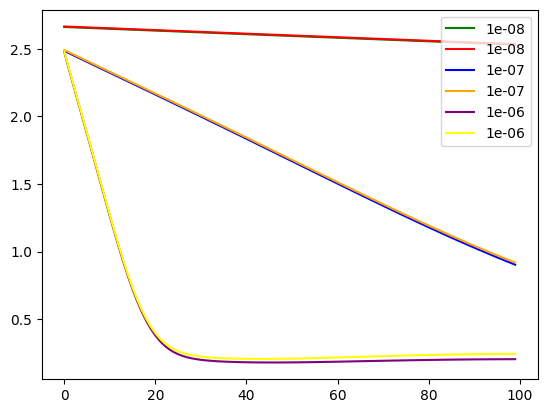

In [33]:
# Evaluate effect of learning rate (next try with more epochs for middle rate):

# Set parameters for model runs
n_batch = 32 # 4, 32, 64 Note: Number of train and test samples must be divisible by the batch size
n_epochs = 100 #200
n_neurons = 100 #100
#learning_rates = [0.00000001, 0.0000001, 0.000001, 0.00001] #0.00000001 seems to be the best learning rate so far
learning_rates = [0.00000001, 0.0000001, 0.000001]
regularizer = l2(0.1)
train_colors = ['green', 'blue', 'purple']
test_colors = ['red', 'orange', 'yellow']

# Dictionary to store model and history outputs
model_history = collections.defaultdict()

# Run diagnostic experiments
def run():
    # Run diagnostic tests
    for i, rate in enumerate(learning_rates):
        model, history = fit_lstm(
            X_train_data=X_train, #[:2,:,:],
            X_test_data=X_test, #[:2,:,:],
            y_train_data=y_train, #[:2,:],
            y_test_data=y_test, #[:2,:],
            X_train_raw_data=X_train_raw, #[:2,:,:],
            X_test_raw_data=X_test_raw, #[:2,:,:],
            y_train_raw_data=y_train_raw, #[:2,],
            y_test_raw_data=y_test_raw, #[:2,],
            scaler=scaler, 
            batch_size=n_batch, 
            nb_epoch=n_epochs, 
            neurons=n_neurons, 
            learning_rate=rate, 
            reg=regularizer)
        
        # Plot training and testing RMSE over epochs
        plt.plot(history['train'], color=train_colors[i], label=rate)
        plt.plot(history['test'], color=test_colors[i], label=rate)
        legend = plt.legend(loc='upper right')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
        plt.savefig('model_runs/nowcast_LRlow_diagnostic.png')
        # Save outputs
        model_history[f'learning_rate_{rate}'] = [model, history]

run()

In [44]:
# Save the scaler
scaler_filename = "aqi_scaler.joblib"
joblib.dump(scaler, scaler_filename)

['aqi_scaler.joblib']

In [45]:
# Save the model
model_filename = "aqi_LSTM.joblib"
current_model = model_history.get('learning_rate_1e-06')[0]
#model_history
#current_model.output_shape
#invert_scale_diff(current_model.predict(X_train[1:2,:,:]), prev=X_raw[:1,:].reshape(1,24,1), scaler=scaler, steps_in=n_steps_in, steps_out=n_steps_out)
joblib.dump(current_model, model_filename)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-01-13 02:58:01         2284
metadata.json                                  2023-01-13 02:58:01           64
variables.h5                                   2023-01-13 02:58:01       524808


['aqi_LSTM.joblib']